In [99]:
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
from mmdet.registry import VISUALIZERS
import mmcv

In [100]:
config_file = 'checkpoint_config/detr_more_transformations.py'
checkpoint_file = 'checkpoint_config/epoch_1000.pth'

In [101]:
#Register all modules in mmdet into the registries
register_all_modules()
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cpu'
classes = ['MEŠ', 'MU', 'E', 'MA', 'LA', 'ŠA₃', 'RU', 'KA', 'DA', 'A', 'TA', '|HI×AŠ₂|', 'I', 'RI', 'LU', 'GUR', 'DI', 'EN', 'KI', 'IG', 'NA', 'UD', 'UB', 'BU', 'IGI', 'KUR', 'U₂', 'SI', 'BA', 'GI', 'DIM₂', 'MI', 'HI', 'ŠU', 'SA', 'NI', 'ŠU₂', 'NU', 'BI', 'AN', 'HA', 'RA', 'GAL', 'ŠE', 'AŠ', '|I.A|', 'U', 'LUGAL', 'SAL', 'ZE₂', 'GA', 'DU', 'UnclearSign', 'TI', 'DIŠ', 'AK', 'GAR', 'UN', 'DIN', 'A₂', 'ME', 'IŠ', 'KU', '|UD×(U.U.U)|', 'TAR', 'LU₂', 'ZI', 'BAD', 'ŠEŠ', 'KAK', '|HI×BAD|', 'ZU', 'PAP', 'MAŠ', 'TUR', 'PI', 'GIŠ', 'UŠ', '|U.GUD|', 'TU', 'AB', 'MIN', 'ZA', 'TUM', 'E₂', 'TE', 'HU', '|U.U|', 'IB', 'PA', 'LI', 'AD', 'ŠA', '|U.KA|', 'UR', 'SAG', 'SU', 'URU', '|U.U.U|', 'KAL', 'NE', 'NAM', 'KU₃', 'DUN₃@g', 'IM', 'KID']


Loads checkpoint by local backend from path: Checkpoints/more_transform/epoch_1000.pth


In [102]:
# test a single image
img = mmcv.imread('K.2.jpg', channel_order='rgb')
result = inference_detector(model, img)
print(result)

<DetDataSample(

    META INFORMATION
    img_path: None
    pad_shape: (800, 1089)
    batch_input_shape: (800, 1089)
    img_id: 0
    img_shape: (800, 1089)
    ori_shape: (915, 1245)
    scale_factor: (0.8746987951807229, 0.8743169398907104)

    DATA FIELDS
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([  1, 105, 105,  16,  12,  52,   3,  14,  18,   9, 105,  14, 105,  12,
                          2,   8,  52,  85,   9,  52,  12,  52,  11,  51,  14,  14,  20, 100,
                         53,  39,  16,  36,  10,  51,   9,  52,  71,  57,  18,   9,  52,  41,
                         52,  37,   9,  60,  52,  52,   9,  52,  43,  46,  52,  52,  52,  71,
                         52,  18,  52,   9,   9,   3,  52,  39,  52,  52,  18,  39,  16,  39,
                         18,  52,  12,  52,  18,  35,  24,  52,  16,  18,  52,  52,  11,  65,
                         36, 105,   4,  96,  85,  33,  16,   9,

In [103]:
indexes = list(result.pred_instances.labels)
def get_classes_at_indexes(classes, indexes):
    result = []
    for index in indexes:
        if index < len(classes):
            result.append(classes[index])
        else:
            result.append(None)  # Handle out-of-range indexes by adding None
    return result

In [104]:
preds = get_classes_at_indexes(classes, indexes)

In [105]:
print(preds)

['MU', 'KID', 'KID', 'DI', 'I', 'UnclearSign', 'MA', 'LU', 'KI', 'A', 'KID', 'LU', 'KID', 'I', 'E', 'DA', 'UnclearSign', 'TE', 'A', 'UnclearSign', 'I', 'UnclearSign', '|HI×AŠ₂|', 'DU', 'LU', 'LU', 'NA', 'NE', 'TI', 'AN', 'DI', 'ŠU₂', 'TA', 'DU', 'A', 'UnclearSign', 'ZU', 'UN', 'KI', 'A', 'UnclearSign', 'RA', 'UnclearSign', 'NU', 'A', 'ME', 'UnclearSign', 'UnclearSign', 'A', 'UnclearSign', 'ŠE', 'U', 'UnclearSign', 'UnclearSign', 'UnclearSign', 'ZU', 'UnclearSign', 'KI', 'UnclearSign', 'A', 'A', 'MA', 'UnclearSign', 'AN', 'UnclearSign', 'UnclearSign', 'KI', 'AN', 'DI', 'AN', 'KI', 'UnclearSign', 'I', 'UnclearSign', 'KI', 'NI', 'IGI', 'UnclearSign', 'DI', 'KI', 'UnclearSign', 'UnclearSign', '|HI×AŠ₂|', 'LU₂', 'ŠU₂', 'KID', 'LA', 'SU', 'TE', 'ŠU', 'DI', 'A', 'DI', 'UnclearSign', 'UnclearSign', 'DA', 'UnclearSign', 'UnclearSign', 'GAR', 'SU']


In [106]:
# init the visualizer(execute this block only once)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta

d:\Anaconda\envs\OCR\Lib\site-packages\mmengine\utils\manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


d:\Anaconda\envs\OCR\Lib\site-packages\mmengine\visualization\visualizer.py:760: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
d:\Anaconda\envs\OCR\Lib\site-packages\mmengine\visualization\visualizer.py:831: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(


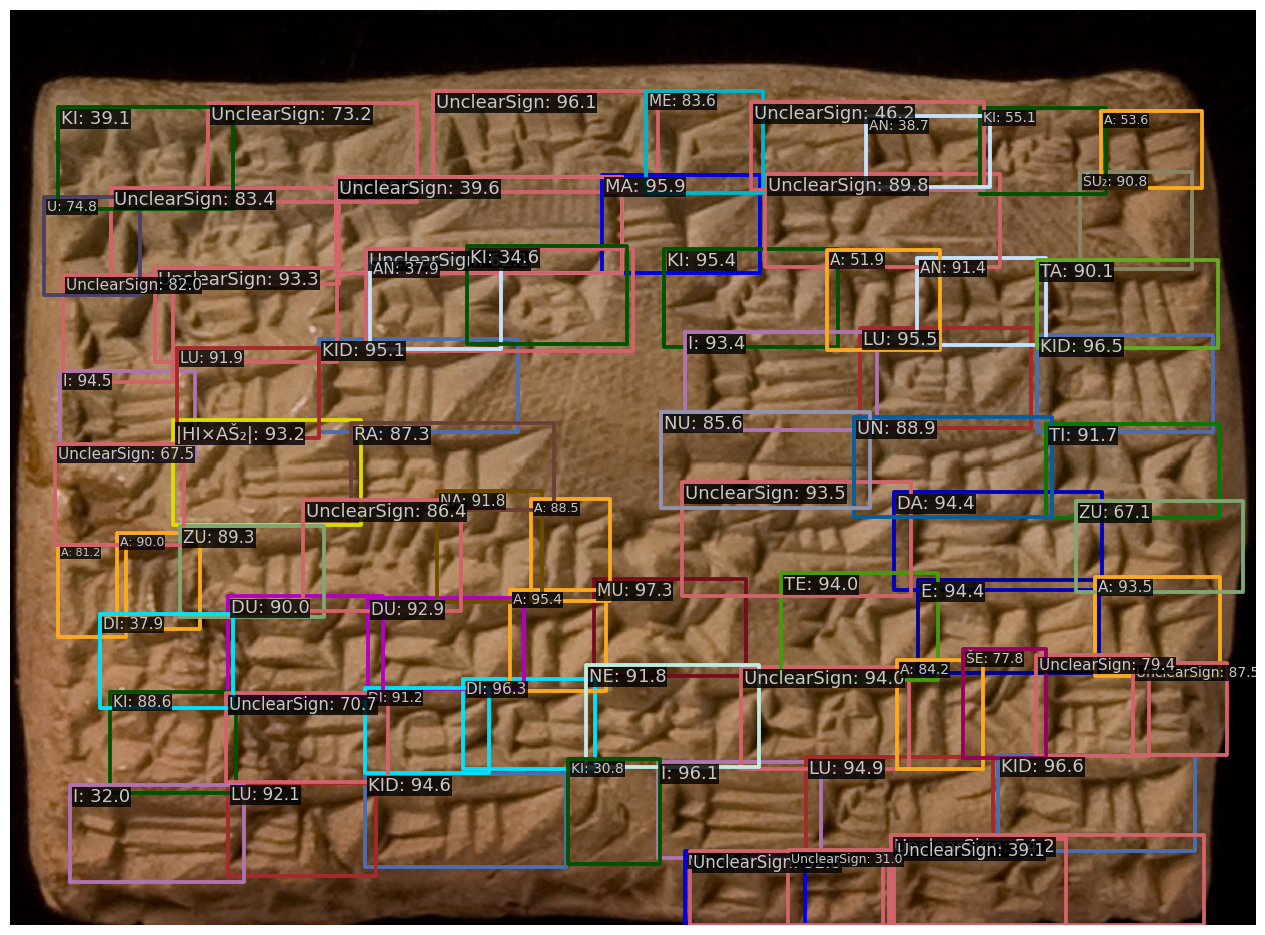

In [107]:
# show the results
visualizer.add_datasample(
    'result',
    img,
    data_sample=result,
    draw_gt=False,
    wait_time=0,
    
)
visualizer.show()
visualizer.fig_save